In [73]:
import scipy.signal as signal # low-pass filter
from statsmodels.tsa.tsatools import detrend # detrend timeseries
from statsmodels.tsa.seasonal import seasonal_decompose # deseasonalize timeseries
from sklearn.preprocessing import StandardScaler

import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [61]:
data_fp = '../solodoch_data_minimal/26N.nc'

ecco_data = xr.open_dataset(data_fp)
ssh = ecco_data['SSH'].values.squeeze()

In [3]:
ssh_detrend = detrend(ssh, order = 1, axis = 0)

In [64]:
ssh_deseason = seasonal_decompose(ssh, model = 'additive', period = 12, extrapolate_trend = 6) # should detrend and deseason, use the residuals!

In [69]:
(np.abs((ssh_deseason.trend + ssh_deseason.seasonal + ssh_deseason.resid) - ssh) < 0.01).sum()

47232

In [25]:
scaler = StandardScaler()
ssh_new = scaler.fit_transform(ssh).reshape(ssh.shape[0], 1, ssh.shape[1])
ssh_new.shape

(288, 1, 164)

In [26]:
new_array = xr.full_like(ecco_data, 0)
dims = ('time', 'latitude', 'longitude')
new_array['SSH'] = (dims, ssh_new)

In [32]:
list(new_array.keys())

['SSH', 'ZWS', 'OBP', 'SSS', 'SST']

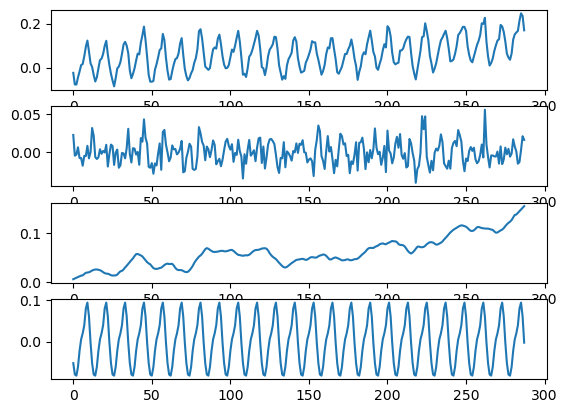

In [65]:
lon = 0

fig, axs = plt.subplots(4, 1)

axs[0].plot(ssh[ : , lon])
axs[1].plot(ssh_deseason.resid[ : , lon])
axs[2].plot(ssh_deseason.trend[ : , lon])
axs[3].plot(ssh_deseason.seasonal[ : , lon])

plt.show()

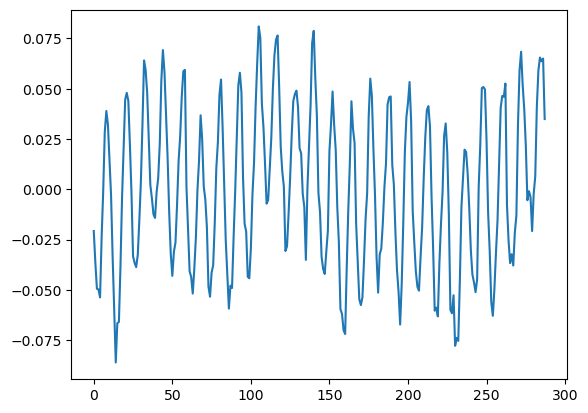

In [72]:
plt.plot(ssh_detrend[ : , lon])

In [155]:
dummy_ts = ssh_deseason.resid[ : , 0]

In [244]:
cutoff = 2.0
fs = 12.0
order = 3

b, a = signal.butter(order, cutoff, fs = fs, btype = 'low', analog = False)
filtered = signal.lfilter(b, a, ssh_deseason.resid, axis = 0)

In [245]:
filtered.shape

(288, 164)

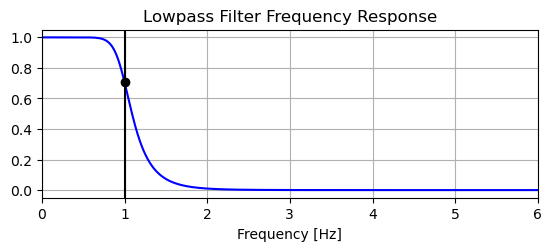

In [169]:
# Plot the frequency response.
w, h = signal.freqz(b, a, fs=fs, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(w, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

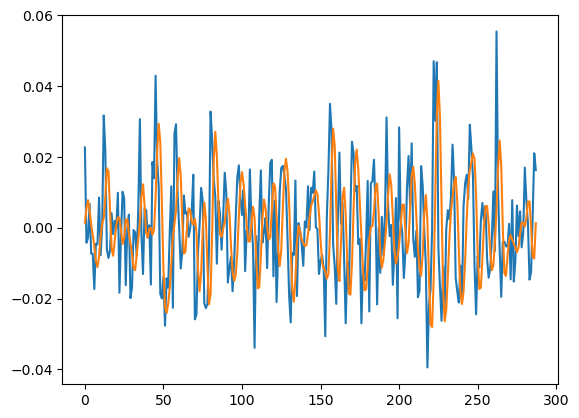

In [246]:
plt.plot(ssh_deseason.resid[ : , 0])
plt.plot(filtered[ : , 0])

In [203]:
rapid = xr.open_dataset('../RAPID/moc_transports.nc')
rapid_np = rapid['moc_mar_hc10'].resample(time = 'MS').mean().values
rapid_deseason = seasonal_decompose(rapid_np, model = 'additive', period = 12, extrapolate_trend = 6).resid

In [238]:
cutoff = 2.0
fs = 12.0
order = 6

b, a = signal.butter(order, cutoff, fs = fs, btype = 'low', analog = False)
filtered = signal.filtfilt(b, a, rapid_deseason)

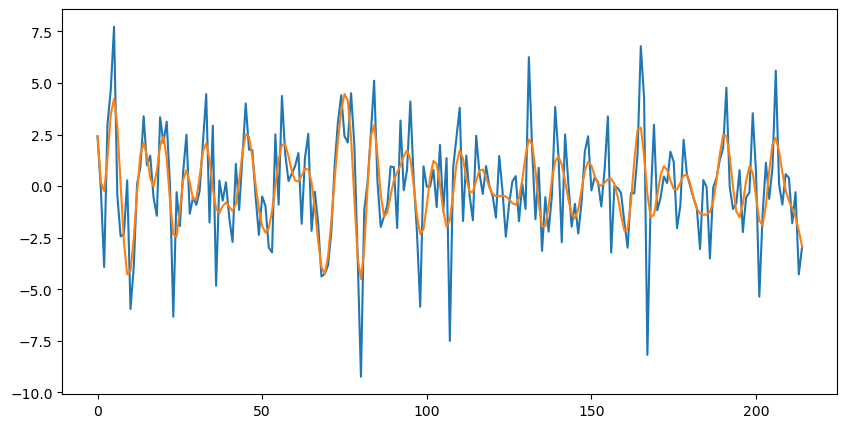

In [239]:
plt.figure(figsize = (10, 5))
plt.plot(rapid_deseason)
plt.plot(filtered)